# Neural Network

## Table of content

- [Experiment on how imbalance affect the performance](#experiment-on-how-imbalance-affect-the-performance)
    - [Without handling imbalance](#Without-handling-imbalance)
    - [Using class weights](#Using-class-weights)
    - [Using oversampling ](#Using-oversampling )
    - [Results of the experiment](#Results-of-the-experiment)
- [Find the best model](#Find-the-best-model)

In [1]:
from Functions import get_result, get_best_threshold, plot_roc_curve, challenge_champion
from imblearn.over_sampling import SMOTE
from keras import Sequential, models, utils, backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import (AUC, BinaryAccuracy, Precision, Recall, Metric, F1Score, 
                           TruePositives, FalsePositives, TrueNegatives, FalseNegatives)
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.utils import class_weight
import datetime
import json
import keras_tuner as kt
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import numpy as np
import optuna
import pandas as pd
import tensorflow as tf

2025-12-17 10:22:18.644313: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 10:22:19.002765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-17 10:22:19.002819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-17 10:22:19.059985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-17 10:22:19.175740: I tensorflow/core/platform/cpu_feature_guar

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [3]:
BATCH_SIZE = 2048

In [4]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

2025-12-17 10:22:22.022311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-17 10:22:22.228183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-17 10:22:22.228243: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-17 10:22:22.231544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-17 10:22:22.231605: I external/local_xla/xla/stream_executor

We will start by creating a function to produce some plots of the models performance and loss on the training and validation set. These will help us check for overfitting.

In [5]:
def plot_training_metrics(history):
    metrics = [
        'loss', 
        'recall', 
        'precision', 
        #'F1'
        'prc'
    ]
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

Now, lets do an experiment of how our neural network would do, when we do not handle the imbalance in our dataset. Afterwards we'll try two different techniques to handle the imbalance.

## Experiment on how imbalance affect the performance
We'll create a function to create a simple model, which we can use for this experiment.

In [6]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(from_logits=False),
        metrics=METRICS
    )

    return model

### Without handling imbalance

In [7]:
model = get_simple_model()

In [8]:
history_unhandled = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20


2025-12-17 10:22:25.807705: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-12-17 10:22:27.437923: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff1b4197630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-17 10:22:27.437958: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-12-17 10:22:27.454397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-17 10:22:27.488913: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1765963347.559630  360929 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 [==============================] - 8s 18ms/step - loss: 0.0392 - tp: 4.0000 - fp: 1793.0000 - tn: 270766.0000 - fn: 381.0000 - accuracy: 0.9920 - precision: 0.0022 - recall: 0.0104 - prc: 0.0014 - val_loss: 0.0125 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 34070.0000 - val_fn: 48.0000 - val_accuracy: 0.9986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.0019
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.0111 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.0015 - val_loss: 0.0105 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 34070.0000 - val_fn: 48.0000 - val_accuracy: 0.9986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.0014
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.0110 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accuracy: 0.9986 - precision: 0

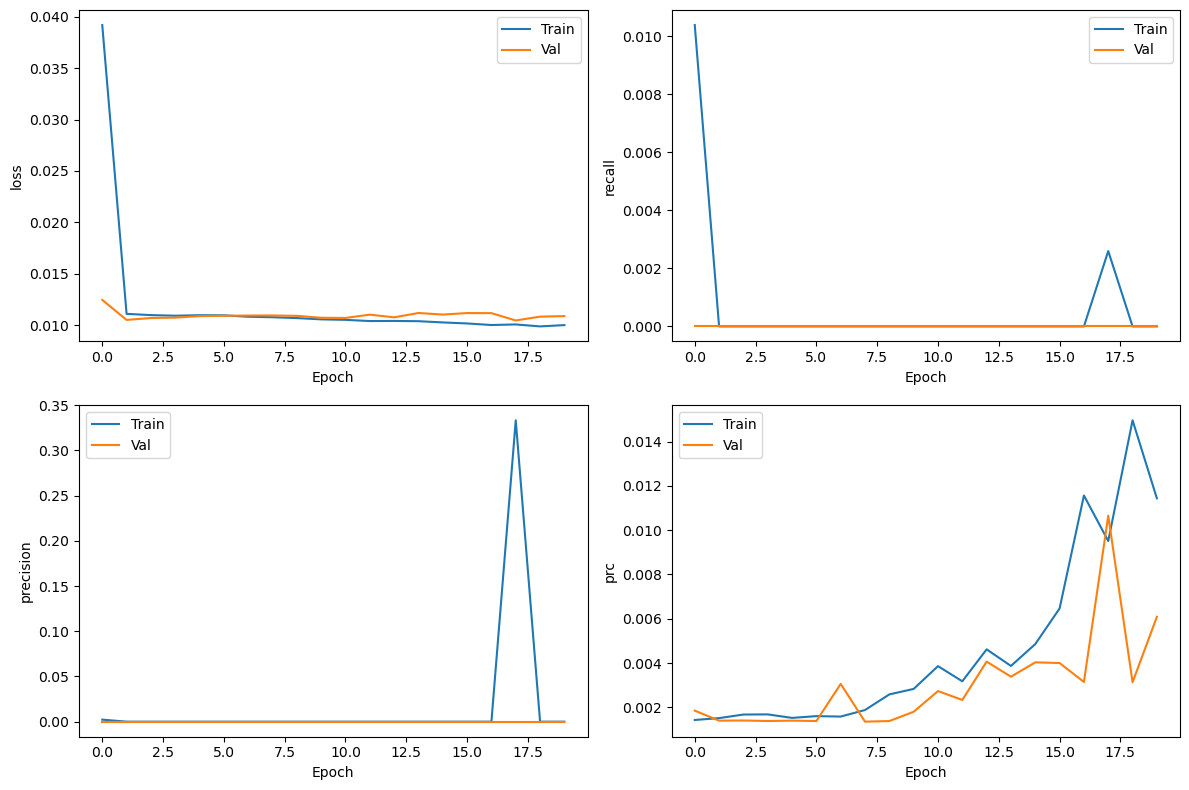

In [9]:
plot_training_metrics(history_unhandled)

In [10]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


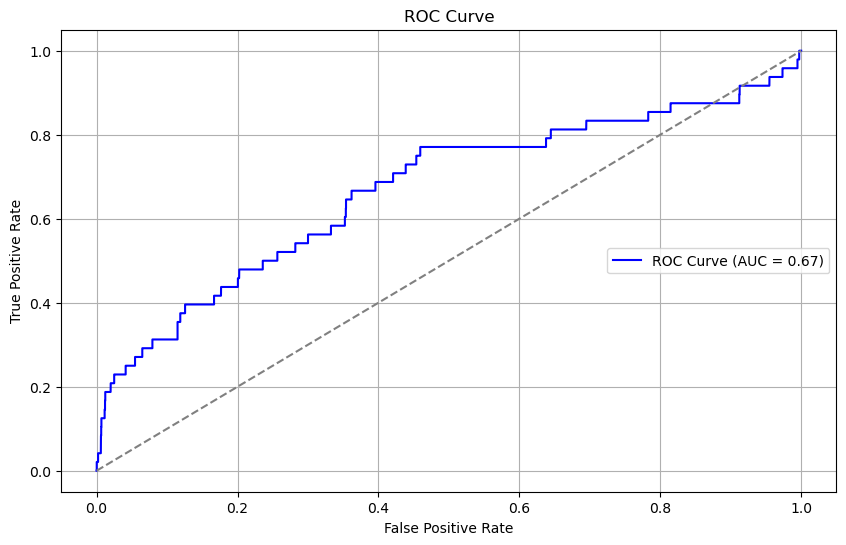

0.6690698072595636

In [11]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:77: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


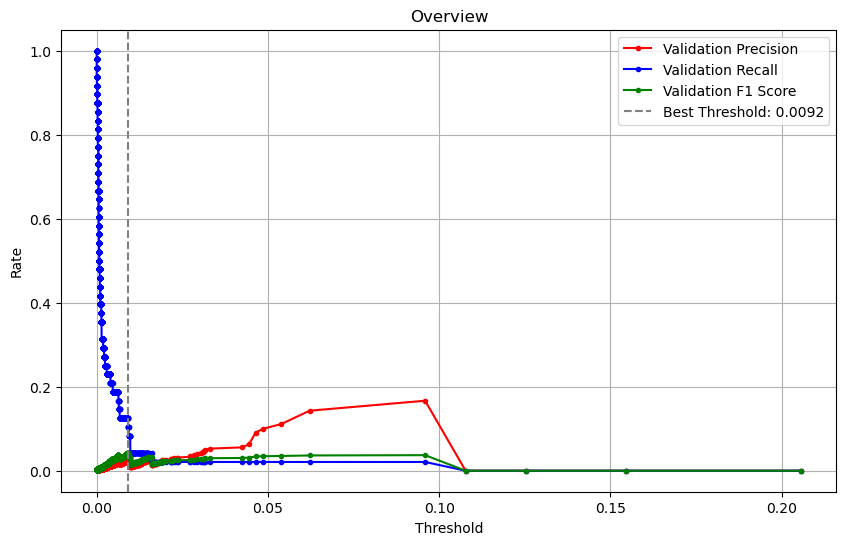

In [12]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [13]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


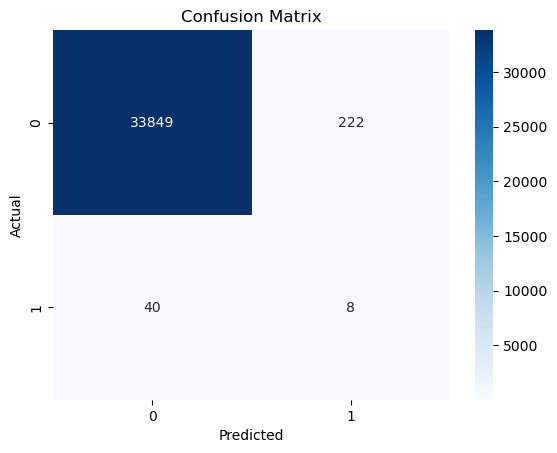

Accuracy     = 0.99
Recall       = 0.17
Precision    = 0.03
F1           = 0.06


In [14]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Using class weights

In [15]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5007062691013688, 1: 354.4727272727273}

In [16]:
model = get_simple_model()

history_class_weights = model.fit(
    X_train,
    Y_train,
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 5s 17ms/step - loss: 0.7906 - tp: 205.0000 - fp: 135788.0000 - tn: 170841.0000 - fn: 228.0000 - accuracy: 0.5570 - precision: 0.0015 - recall: 0.4734 - prc: 0.0016 - val_loss: 0.7032 - val_tp: 28.0000 - val_fp: 19478.0000 - val_tn: 14592.0000 - val_fn: 20.0000 - val_accuracy: 0.4285 - val_precision: 0.0014 - val_recall: 0.5833 - val_prc: 0.0066
Epoch 2/20
134/134 [==============================] - 2s 13ms/step - loss: 0.7322 - tp: 213.0000 - fp: 130297.0000 - tn: 142262.0000 - fn: 172.0000 - accuracy: 0.5220 - precision: 0.0016 - recall: 0.5532 - prc: 0.0018 - val_loss: 0.7732 - val_tp: 37.0000 - val_fp: 23608.0000 - val_tn: 10462.0000 - val_fn: 11.0000 - val_accuracy: 0.3077 - val_precision: 0.0016 - val_recall: 0.7708 - val_prc: 0.0047
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.7270 - tp: 229.0000 - fp: 133979.0000 - tn: 138580.0000 - fn: 156.0000 - accuracy: 0.5086 - precision: 0.0017 - recall: 0

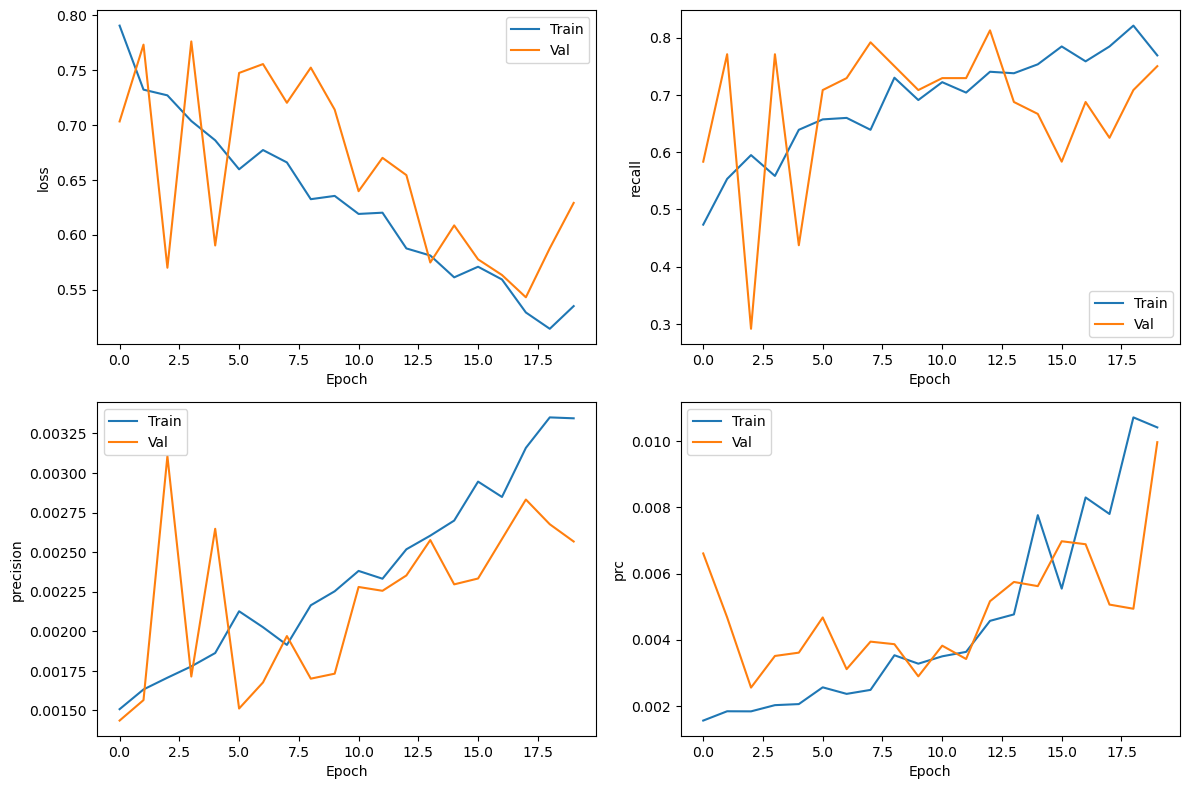

In [17]:
plot_training_metrics(history_class_weights)

In [18]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


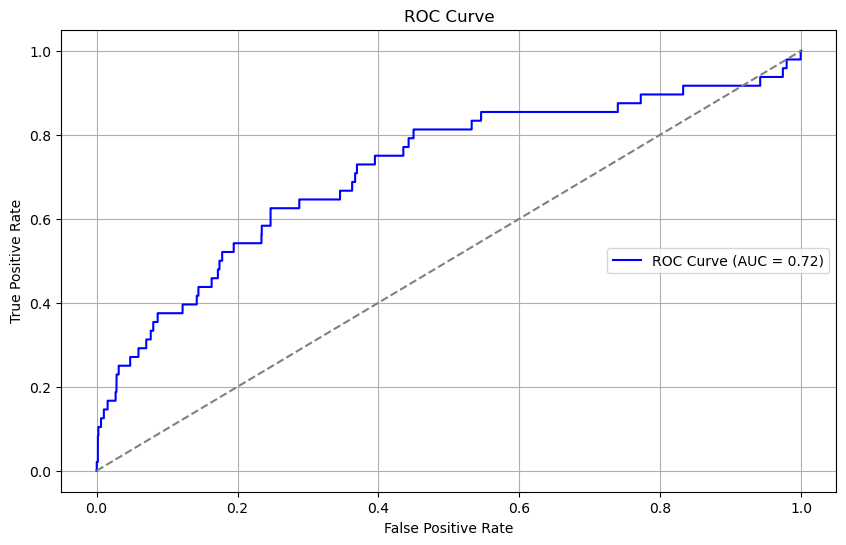

0.716647710595832

In [19]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:77: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


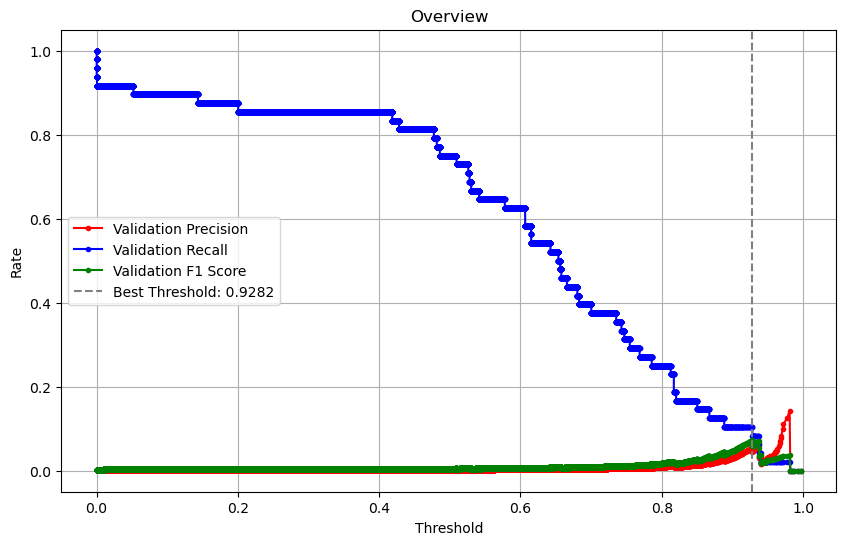

In [20]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [21]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


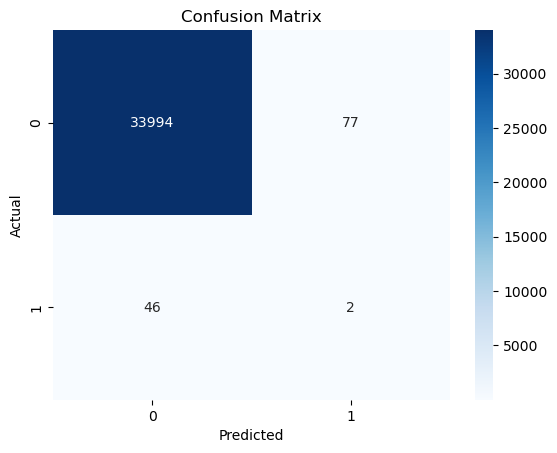

Accuracy     = 1.0
Recall       = 0.04
Precision    = 0.03
F1           = 0.03


In [22]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Using oversampling 

There are different kinds of techniques for oversampling. The simplest would be Random oversampling, which just duplicates existing samples from the minority class to balance the distribution. However, this can result in overfitting as the same samples are repeated. Instead we could use Synthetic Minority Over-sampling Technique (SMOTE). The way SMOTE does it, is by generating synthetic examples in the feature space of the minority class, which helps to overcome the overfitting problem, since it is not just a copy of existing samples. The drawback of SMOTE is it can generate noisy or unrealistic samples. We will however use SMOTE to oversample on the risky customers.

In [23]:
smote = SMOTE(sampling_strategy='minority') 
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)
Y_train_oversampled.value_counts()

RISK
0    272559
1    272559
Name: count, dtype: int64

In [24]:
model = get_simple_model()

history_oversampled = model.fit(
    X_train_oversampled,
    Y_train_oversampled,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
267/267 [==============================] - 6s 15ms/step - loss: 0.3267 - tp: 243298.0000 - fp: 67407.0000 - tn: 239222.0000 - fn: 29309.0000 - accuracy: 0.8330 - precision: 0.7831 - recall: 0.8925 - prc: 0.9116 - val_loss: 3.5773 - val_tp: 48.0000 - val_fp: 33139.0000 - val_tn: 931.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0287 - val_precision: 0.0014 - val_recall: 1.0000 - val_prc: 0.0045
Epoch 2/20
267/267 [==============================] - 4s 13ms/step - loss: 0.1248 - tp: 265094.0000 - fp: 17226.0000 - tn: 255333.0000 - fn: 7465.0000 - accuracy: 0.9547 - precision: 0.9390 - recall: 0.9726 - prc: 0.9836 - val_loss: 0.5443 - val_tp: 29.0000 - val_fp: 6699.0000 - val_tn: 27371.0000 - val_fn: 19.0000 - val_accuracy: 0.8031 - val_precision: 0.0043 - val_recall: 0.6042 - val_prc: 0.0278
Epoch 3/20
267/267 [==============================] - 4s 14ms/step - loss: 0.0889 - tp: 267386.0000 - fp: 11616.0000 - tn: 260943.0000 - fn: 5173.0000 - accuracy: 0.9692 - precision: 0.9584 -

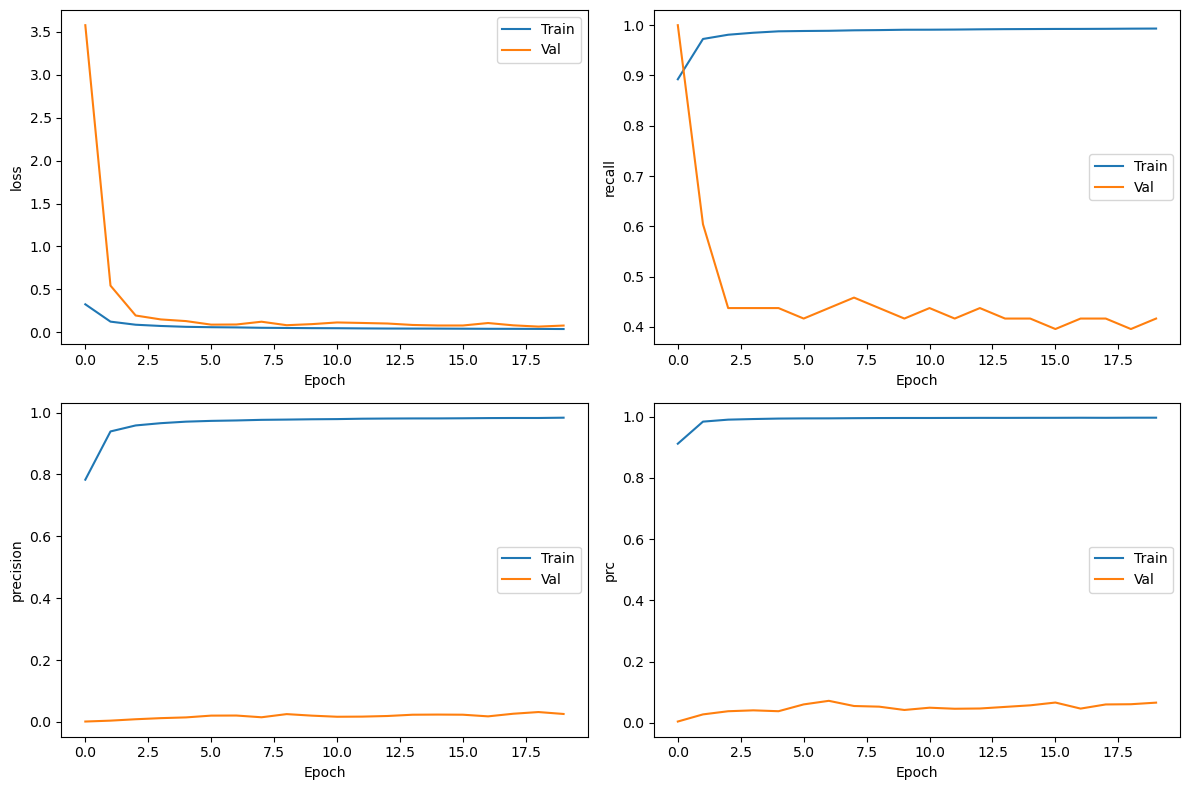

In [25]:
plot_training_metrics(history_oversampled)

In [26]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 3ms/step


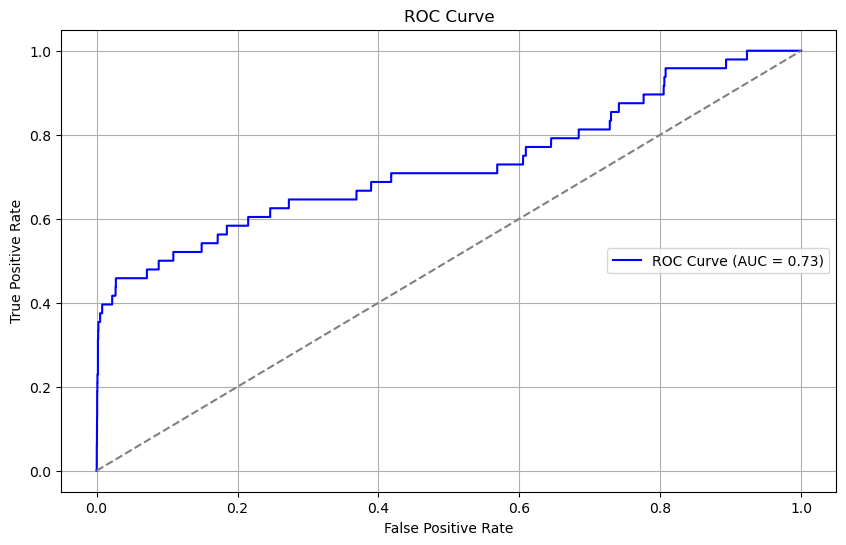

0.7267696409353291

In [27]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:77: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


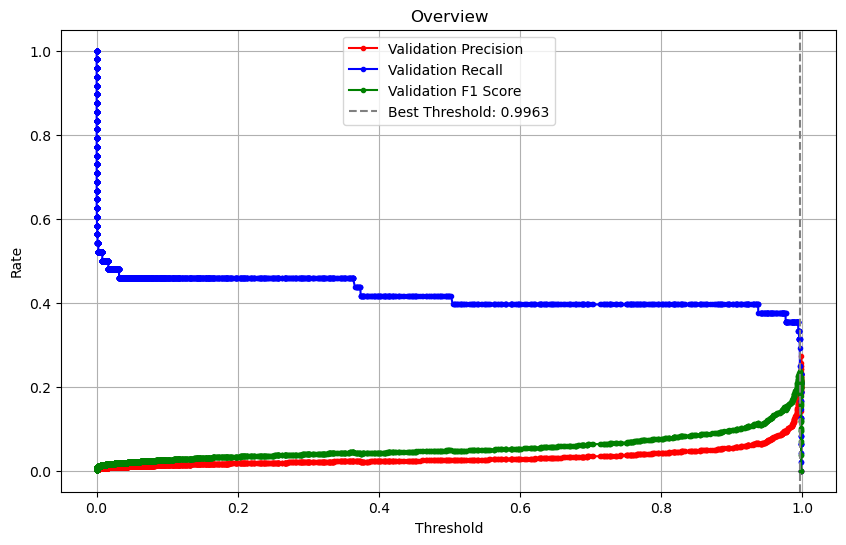

In [28]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [29]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


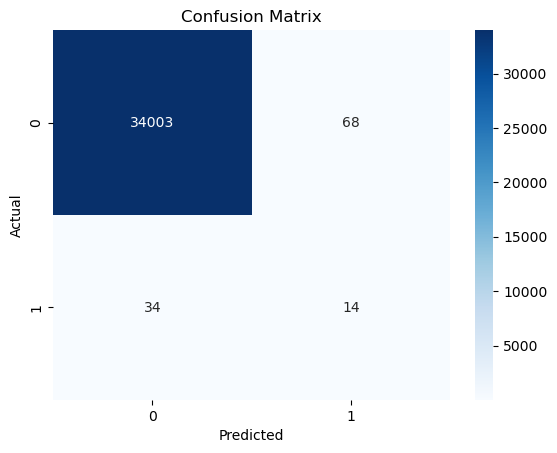

Accuracy     = 1.0
Recall       = 0.29
Precision    = 0.17
F1           = 0.22


In [30]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Results of the experiment
- All the models could use some regularization (we will handle that later)
- Using nothing to handle the imbalance did okay but not good (was not the point here)
- Using class weights was the worst of the three models
    - Could be the result of too high a weight for the risky customers and too low for the normal customers, which would mean that the model focuses more on reducing errors for risky customers. However, it did not do much better on the recall anyway. Trying out different weights could improve the performance.
- Using oversampling was the the best but again not really good.

Handling imbalance is clearly an important part to create a good model. However as demonstrated, you need to test out different methods to find out what works best.

## Find the best model
First lets set up MLflow to track our experiment

In [31]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

client = mlflow.tracking.MlflowClient()

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [32]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1764788131496, experiment_id='1', last_update_time=1764788131496, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.experimentKind': 'custom_model_development',
 'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

In [33]:
base_run_name = "neaural_network"

In [34]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'neaural_network': 0


In [35]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'neaural_network_v1'

Now lets try to find the possible model. To do that we'll create a function that can build a model with different hyperparameters.

In [36]:
def build_model(trial):
    """
    Build and compile a model using different hyperparameters.

    Parameters:
        trial (optuna.trial.Trial): Object for defining hyperparameter search space.

    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()

    # Input layer units
    input_units = trial.suggest_int("input_layer", 64, 512, step=32)
    l2_input = trial.suggest_float("l2_0", 1e-4, 1e-2, log=True)  

    model.add(
        Dense(
            units=input_units,
            input_shape=(X_train_oversampled.shape[1],),
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(l2_input),
        )
    )

    # Always add a Dropout layer after the first layer
    model.add(Dropout(rate=trial.suggest_float("dropout_input", 0.2, 0.5)))

    # Number of hidden layers
    n_layers = trial.suggest_int("num_layers", 1, 5)
    previous_units = input_units

    for i in range(n_layers):
        units_i = trial.suggest_int(f"units_{i+1}", 32, previous_units, step=32)
        l2_i = trial.suggest_float(f"l2_{i+1}", 1e-4, 1e-2, log=True)

        model.add(
            Dense(
                units=units_i,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(l2_i),
            )
        )

        # Optional batch norm
        if trial.suggest_categorical(f"batch_norm_{i}", [False, True]):
            model.add(BatchNormalization())

        # Optional dropout
        if trial.suggest_categorical(f"dropout_{i}", [False, True]):
            model.add(Dropout(rate=trial.suggest_float(f"dropout_rate_{i}", 0.2, 0.5)))

        previous_units = units_i

    model.add(Dense(1, activation="sigmoid"))

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [37]:
# Metric we want to monitor during training
monitor = 'val_prc'

In [38]:
# Apply SMOTE to training data to handle class imbalance (again for clarity)
smote = SMOTE(sampling_strategy='minority') 
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)
Y_train_oversampled.value_counts()

RISK
0    272559
1    272559
Name: count, dtype: int64

We are going to utilize a callback when running the RandomSearch:
- EarlyStopping: To stop training when the model stop to improve on the monitored metric for a number of epochs. Here we also restore the weights, which resulted in the best performence on the monitored metric.

In [39]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [BATCH_SIZE, BATCH_SIZE * 2])

    model = build_model(trial)

    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=3,
        mode="max",
        restore_best_weights=True,
    )

    with mlflow.start_run(nested=True):
        history = model.fit(
            X_train_oversampled,
            Y_train_oversampled,
            epochs=20,
            batch_size=batch_size,
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping],
            verbose=0,
        )

        # Evaluate the model
        preds = model.predict(X_val, batch_size=batch_size)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(trial.params)
        mlflow.log_params({"epochs": len(history.history['loss'])})
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        # Log tags
        mlflow.set_tags(
            tags={
                "project": "Credit Card Approval",
                "optimizer_engine": "optuna",
                "model_family": "Neaural Network",
                "feature_set_version": 1,
                "version": int(len(prior_runs))+1
            }
        )

    return metrics['f1']

In [40]:
artifact_path = "model"

with mlflow.start_run(run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    study = optuna.create_study(
        direction="maximize",
        study_name="NeauralNetwork_Optimization",
    )

    study.optimize(objective, n_trials=50)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "Neaural Network",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    # train the final model with the best hyperparameters
    best_trial = study.best_trial
    model = build_model(best_trial)

    # Before training the best model again, we are going to utilize some additional callbacks:
    # - ModelCheckpoint: To save the best weights depending on a monitored metric.
    # - TensorBoard: To visualize training progress and metrics in TensorBoard.
    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=5,
        mode="max",
        restore_best_weights=True,
    )

    # Model checkpoint callback for securing best weights
    model_checkpoint_callback = ModelCheckpoint(
        filepath=r'tmp/NN_best_model.keras',
        save_weights_only=True, 
        monitor=monitor,
        mode='max',
        save_best_only=True
    )

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # directory to store logs
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(
            X_train_oversampled,
            Y_train_oversampled,
            epochs=50,
            batch_size=study.best_params['batch_size'],
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback],
            verbose=0,
        )
    
    # Evaluate the model
    preds = model.predict(X_val, batch_size=study.best_params['batch_size'])
    metrics = get_result(Y_val, preds)

    # Log the number of epochs
    mlflow.log_params({"epochs": len(history.history['loss'])})
    
    # Log the metrics
    mlflow.log_metrics(metrics)

    # Log the final model
    model_info = mlflow.keras.log_model(model, 
                            #  artifact_path=artifact_path
                            name=artifact_path,
                            #input_example=X_train_oversampled.iloc[[0]]
                             )
    model_uri = model_info.model_uri

[I 2025-12-17 10:25:04,261] A new study created in memory with name: NeauralNetwork_Optimization


17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:25:25,911] Trial 0 finished with value: 0.059880239520958084 and parameters: {'batch_size': 2048, 'input_layer': 192, 'l2_0': 0.00034859942295223714, 'dropout_input': 0.21158008192270758, 'num_layers': 1, 'units_1': 64, 'l2_1': 0.0006339818025350247, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.3812604068517413, 'learning_rate': 0.009821935637278218}. Best is trial 0 with value: 0.059880239520958084.


🏃 View run rare-cub-348 at: http://127.0.0.1:8080/#/experiments/1/runs/1f91b5ec3c8d435d8150dab0b621af4f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:25:41,690] Trial 1 finished with value: 0.11965811965811966 and parameters: {'batch_size': 2048, 'input_layer': 128, 'l2_0': 0.0010277766407886808, 'dropout_input': 0.28644397315801584, 'num_layers': 2, 'units_1': 32, 'l2_1': 0.00777776447646967, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.4572647793050309, 'units_2': 32, 'l2_2': 0.00031804113139459646, 'batch_norm_1': True, 'dropout_1': False, 'learning_rate': 0.004907795953447125}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run handsome-steed-545 at: http://127.0.0.1:8080/#/experiments/1/runs/ed2d278e74c94ca5ae91ad63931267e9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-17 10:25:56,192] Trial 2 finished with value: 0.07712082262210797 and parameters: {'batch_size': 4096, 'input_layer': 512, 'l2_0': 0.009738744416377848, 'dropout_input': 0.23518911301184334, 'num_layers': 5, 'units_1': 448, 'l2_1': 0.0005946898632729836, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 32, 'l2_2': 0.0001556662365452036, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.0003969349553127958, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 32, 'l2_4': 0.002067284561090256, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.00023516989793483513, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.003109262648125966}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run wise-mole-214 at: http://127.0.0.1:8080/#/experiments/1/runs/550c436b374a40559273fc590e57b8e7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:26:15,071] Trial 3 finished with value: 0.11428571428571428 and parameters: {'batch_size': 2048, 'input_layer': 256, 'l2_0': 0.0004670575423030429, 'dropout_input': 0.23763360709444217, 'num_layers': 3, 'units_1': 160, 'l2_1': 0.00023163157959541514, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.30008512014111266, 'units_2': 64, 'l2_2': 0.0006136086175084061, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.000673301360748716, 'batch_norm_2': False, 'dropout_2': False, 'learning_rate': 0.005469095538312463}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run useful-calf-578 at: http://127.0.0.1:8080/#/experiments/1/runs/5e7849a899b1453f97cd8bf34b24efa8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:26:26,383] Trial 4 finished with value: 0.04207920792079208 and parameters: {'batch_size': 2048, 'input_layer': 416, 'l2_0': 0.009468101720250408, 'dropout_input': 0.23158656145892847, 'num_layers': 1, 'units_1': 320, 'l2_1': 0.00014635386045541585, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.32725299543756725, 'learning_rate': 0.00609074086254185}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run stately-robin-262 at: http://127.0.0.1:8080/#/experiments/1/runs/ea82285a781f40709eecee157e1d1413
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:26:51,951] Trial 5 finished with value: 0.03431708991077557 and parameters: {'batch_size': 2048, 'input_layer': 384, 'l2_0': 0.00014786008414813639, 'dropout_input': 0.3216357165805329, 'num_layers': 1, 'units_1': 320, 'l2_1': 0.0025185106378217614, 'batch_norm_0': True, 'dropout_0': False, 'learning_rate': 0.00012205885077047993}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run receptive-goose-21 at: http://127.0.0.1:8080/#/experiments/1/runs/a26437c24f2545c0bd1990348385da68
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:27:13,880] Trial 6 finished with value: 0.04885057471264368 and parameters: {'batch_size': 2048, 'input_layer': 448, 'l2_0': 0.0015461392427144243, 'dropout_input': 0.22087658130793195, 'num_layers': 1, 'units_1': 128, 'l2_1': 0.0018197939112499812, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.3084889916084862, 'learning_rate': 0.0024486517267479123}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run fun-ram-58 at: http://127.0.0.1:8080/#/experiments/1/runs/117130d4df9d4785a5517312cabda0f0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:27:27,250] Trial 7 finished with value: 0.05834683954619125 and parameters: {'batch_size': 4096, 'input_layer': 512, 'l2_0': 0.0007935700000772008, 'dropout_input': 0.4365071128502141, 'num_layers': 3, 'units_1': 448, 'l2_1': 0.002726827402116658, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 320, 'l2_2': 0.006407672762771862, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 96, 'l2_3': 0.00030438131958573293, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.36731535235804136, 'learning_rate': 0.000347166517229354}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run welcoming-lynx-858 at: http://127.0.0.1:8080/#/experiments/1/runs/211608cd19ad433e83ac546bcdb9b18d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:28:00,011] Trial 8 finished with value: 0.07108239095315025 and parameters: {'batch_size': 2048, 'input_layer': 288, 'l2_0': 0.00038685206971151307, 'dropout_input': 0.2549949620158238, 'num_layers': 4, 'units_1': 224, 'l2_1': 0.0005228877734824936, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 32, 'l2_2': 0.00024263023808896296, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.46735190299920704, 'units_3': 32, 'l2_3': 0.0005965592504728534, 'batch_norm_2': True, 'dropout_2': False, 'units_4': 32, 'l2_4': 0.005168509155997622, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.0004583311313324286}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run bouncy-lamb-366 at: http://127.0.0.1:8080/#/experiments/1/runs/d81ee8525da049358a9438f6aa3321cc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:28:39,130] Trial 9 finished with value: 0.10023866348448687 and parameters: {'batch_size': 2048, 'input_layer': 384, 'l2_0': 0.0005443601740689402, 'dropout_input': 0.4311460140022029, 'num_layers': 4, 'units_1': 256, 'l2_1': 0.009090843453502957, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.3442422873740155, 'units_2': 160, 'l2_2': 0.004472937217647054, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.2936272629433838, 'units_3': 32, 'l2_3': 0.0023360414315174555, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 32, 'l2_4': 0.002486441988773342, 'batch_norm_3': False, 'dropout_3': True, 'dropout_rate_3': 0.31089646107830304, 'learning_rate': 0.0005206259834846063}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run grandiose-yak-967 at: http://127.0.0.1:8080/#/experiments/1/runs/ccd6e25f01ad4dd2aa2c54a2ac6fef05
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:28:56,092] Trial 10 finished with value: 0.03896103896103896 and parameters: {'batch_size': 4096, 'input_layer': 96, 'l2_0': 0.002458470368365336, 'dropout_input': 0.35185600686516494, 'num_layers': 2, 'units_1': 32, 'l2_1': 0.009808121764234427, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.4966816948757412, 'units_2': 32, 'l2_2': 0.001126409513777852, 'batch_norm_1': True, 'dropout_1': False, 'learning_rate': 0.0014375768724912712}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run gentle-mare-34 at: http://127.0.0.1:8080/#/experiments/1/runs/969ab66d52c94bb28484f9c1813f1939
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:29:29,522] Trial 11 finished with value: 0.02493765586034913 and parameters: {'batch_size': 2048, 'input_layer': 128, 'l2_0': 0.0024744169770063995, 'dropout_input': 0.2987757494706335, 'num_layers': 3, 'units_1': 32, 'l2_1': 0.00012340748803573833, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.21697660977682787, 'units_2': 32, 'l2_2': 0.0006400965215728985, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.0066030935605384256, 'batch_norm_2': False, 'dropout_2': True, 'dropout_rate_2': 0.20453315656119997, 'learning_rate': 0.004457513510926931}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run delightful-shoat-664 at: http://127.0.0.1:8080/#/experiments/1/runs/021afcb24b2b4c92812c8cc30280c6d9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:29:47,952] Trial 12 finished with value: 0.0338680926916221 and parameters: {'batch_size': 2048, 'input_layer': 224, 'l2_0': 0.00018700198932976593, 'dropout_input': 0.30229696502007297, 'num_layers': 2, 'units_1': 128, 'l2_1': 0.00022672480859662, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.48154355853043035, 'units_2': 64, 'l2_2': 0.0006387938847431751, 'batch_norm_1': True, 'dropout_1': False, 'learning_rate': 0.009828531477860279}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run traveling-stoat-433 at: http://127.0.0.1:8080/#/experiments/1/runs/accddf686061434b87ef2858963f7d5d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:30:04,871] Trial 13 finished with value: 0.037037037037037035 and parameters: {'batch_size': 2048, 'input_layer': 64, 'l2_0': 0.0011810584424139172, 'dropout_input': 0.37312905919333206, 'num_layers': 2, 'units_1': 32, 'l2_1': 0.0002982122084967505, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.41378235250700895, 'units_2': 32, 'l2_2': 0.00034451571273004663, 'batch_norm_1': True, 'dropout_1': False, 'learning_rate': 0.0014591422778756215}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run upset-dolphin-661 at: http://127.0.0.1:8080/#/experiments/1/runs/c48d738ba71c4061ac2c39630c903bc4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:30:30,241] Trial 14 finished with value: 0.03685741998060136 and parameters: {'batch_size': 4096, 'input_layer': 192, 'l2_0': 0.004343038461733807, 'dropout_input': 0.27574415130712415, 'num_layers': 4, 'units_1': 96, 'l2_1': 0.004901664880221531, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.26104725241494464, 'units_2': 64, 'l2_2': 0.0018127559073422648, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 64, 'l2_3': 0.00012905778410129745, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 64, 'l2_4': 0.00010131370156520796, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.4998295671249203, 'learning_rate': 0.0026205118403692744}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run capricious-lark-864 at: http://127.0.0.1:8080/#/experiments/1/runs/8d786df7d88840efa1e3e6a45d080a9c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:30:51,131] Trial 15 finished with value: 0.05232558139534884 and parameters: {'batch_size': 2048, 'input_layer': 288, 'l2_0': 0.00032135364388028077, 'dropout_input': 0.3782923231341382, 'num_layers': 3, 'units_1': 192, 'l2_1': 0.001316959314593136, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.4322855702364907, 'units_2': 96, 'l2_2': 0.00038221347597041657, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.20503221709509015, 'units_3': 64, 'l2_3': 0.0017097221993963559, 'batch_norm_2': False, 'dropout_2': False, 'learning_rate': 0.005628617497939241}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run fortunate-owl-137 at: http://127.0.0.1:8080/#/experiments/1/runs/2f815b1521014c61a6ead1890c1584bf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:31:09,321] Trial 16 finished with value: 0.039177277179236046 and parameters: {'batch_size': 2048, 'input_layer': 160, 'l2_0': 0.00010292978156150401, 'dropout_input': 0.49203096520636, 'num_layers': 2, 'units_1': 64, 'l2_1': 0.0002943038408056578, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.2814082341128151, 'units_2': 64, 'l2_2': 0.00012205474227486152, 'batch_norm_1': True, 'dropout_1': False, 'learning_rate': 0.001264569712727121}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run vaunted-skunk-406 at: http://127.0.0.1:8080/#/experiments/1/runs/4510cf4060284d159c30f3f36ea91881
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:31:36,491] Trial 17 finished with value: 0.02880184331797235 and parameters: {'batch_size': 2048, 'input_layer': 256, 'l2_0': 0.0007041533373318314, 'dropout_input': 0.28148910737506094, 'num_layers': 5, 'units_1': 160, 'l2_1': 0.0043480166842301176, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.3903305895088093, 'units_2': 96, 'l2_2': 0.0016361846278637516, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 96, 'l2_3': 0.009883010331253416, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.48622959105190955, 'units_4': 96, 'l2_4': 0.0002755516846805592, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 96, 'l2_5': 0.007361809193928586, 'batch_norm_4': False, 'dropout_4': True, 'dropout_rate_4': 0.46122495138290287, 'learning_rate': 0.0007859419107664591}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run smiling-snake-257 at: http://127.0.0.1:8080/#/experiments/1/runs/7d1dcdd7eb614eaabcb65fb840c7ffb9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:31:50,562] Trial 18 finished with value: 0.075 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.001580158949830998, 'dropout_input': 0.260300046577813, 'num_layers': 3, 'units_1': 160, 'l2_1': 0.000998353831775835, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.0006204622301884162, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.47306130911183325, 'units_3': 128, 'l2_3': 0.00010069570925295128, 'batch_norm_2': False, 'dropout_2': False, 'learning_rate': 0.0039640750437809295}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run skillful-ant-680 at: http://127.0.0.1:8080/#/experiments/1/runs/be9073d5150d4c5684cf905a29367eb9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:32:06,571] Trial 19 finished with value: 0.07293666026871401 and parameters: {'batch_size': 2048, 'input_layer': 64, 'l2_0': 0.00022777235299884982, 'dropout_input': 0.3359809849530616, 'num_layers': 2, 'units_1': 32, 'l2_1': 0.0010317096624292473, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.4482599321969913, 'units_2': 32, 'l2_2': 0.00028100319032369413, 'batch_norm_1': True, 'dropout_1': False, 'learning_rate': 0.002078772659810773}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run painted-moose-590 at: http://127.0.0.1:8080/#/experiments/1/runs/5233fd294d43447c80f81f9bd720b4f3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:32:49,342] Trial 20 finished with value: 0.03650190114068441 and parameters: {'batch_size': 2048, 'input_layer': 128, 'l2_0': 0.0005324078286496728, 'dropout_input': 0.25159196898232195, 'num_layers': 4, 'units_1': 64, 'l2_1': 0.004573670007857992, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.2508949299186056, 'units_2': 64, 'l2_2': 0.0020814478936689008, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.0011913533302960997, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.21327739876000482, 'units_4': 32, 'l2_4': 0.0005417741894694106, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.20034941845310636, 'learning_rate': 0.00021656540425013768}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run learned-bat-499 at: http://127.0.0.1:8080/#/experiments/1/runs/d39f3bf0cb974390a6972a3913f92249
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:33:21,812] Trial 21 finished with value: 0.09844559585492228 and parameters: {'batch_size': 2048, 'input_layer': 352, 'l2_0': 0.0005368825004128608, 'dropout_input': 0.437176654388774, 'num_layers': 4, 'units_1': 256, 'l2_1': 0.009308814184975775, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.34243008317786017, 'units_2': 192, 'l2_2': 0.0089130917143585, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.288273224763404, 'units_3': 64, 'l2_3': 0.0029608498117063156, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 64, 'l2_4': 0.009093517574390435, 'batch_norm_3': False, 'dropout_3': True, 'dropout_rate_3': 0.3046481041983349, 'learning_rate': 0.0007136268338580014}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run receptive-fowl-866 at: http://127.0.0.1:8080/#/experiments/1/runs/272a0e231e71429693f3f8580a797a42
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:33:55,431] Trial 22 finished with value: 0.09230769230769231 and parameters: {'batch_size': 2048, 'input_layer': 448, 'l2_0': 0.001027613987128025, 'dropout_input': 0.41954079262527433, 'num_layers': 4, 'units_1': 288, 'l2_1': 0.006886866567534466, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.36848208178753694, 'units_2': 192, 'l2_2': 0.002799706377897287, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.31023707043884013, 'units_3': 160, 'l2_3': 0.002996748492968933, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 160, 'l2_4': 0.0018951044738161234, 'batch_norm_3': False, 'dropout_3': True, 'dropout_rate_3': 0.3502005437759611, 'learning_rate': 0.000502794896448177}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run bald-lynx-814 at: http://127.0.0.1:8080/#/experiments/1/runs/281a6047b7f44066a24f459abd1d0141
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:34:31,951] Trial 23 finished with value: 0.042105263157894736 and parameters: {'batch_size': 2048, 'input_layer': 320, 'l2_0': 0.0006332100173891007, 'dropout_input': 0.49102265674470513, 'num_layers': 3, 'units_1': 224, 'l2_1': 0.006052644805835025, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.31047312210388517, 'units_2': 160, 'l2_2': 0.004035062446979929, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.3819042494219704, 'units_3': 64, 'l2_3': 0.0007479731812970769, 'batch_norm_2': False, 'dropout_2': False, 'learning_rate': 0.00023860152213651397}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run clumsy-grub-811 at: http://127.0.0.1:8080/#/experiments/1/runs/b8b666a72ebf481ea3fc2719a52999e2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:35:04,392] Trial 24 finished with value: 0.03249630723781388 and parameters: {'batch_size': 2048, 'input_layer': 224, 'l2_0': 0.00043459243492522596, 'dropout_input': 0.20059415137383518, 'num_layers': 5, 'units_1': 96, 'l2_1': 0.0030969805477156285, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.34911569484469895, 'units_2': 64, 'l2_2': 0.0009778596268411423, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.20386127055164951, 'units_3': 32, 'l2_3': 0.0022411112959859945, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 32, 'l2_4': 0.0024464254660763077, 'batch_norm_3': False, 'dropout_3': True, 'dropout_rate_3': 0.3534465446153357, 'units_5': 32, 'l2_5': 0.00010324619803730289, 'batch_norm_4': False, 'dropout_4': False, 'learning_rate': 0.007078097593003334}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run upbeat-bird-733 at: http://127.0.0.1:8080/#/experiments/1/runs/1260d88793264e53ada1efbe1ffde716
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-17 10:35:22,952] Trial 25 finished with value: 0.034454470877768664 and parameters: {'batch_size': 2048, 'input_layer': 384, 'l2_0': 0.00025977780609829666, 'dropout_input': 0.40471075870279455, 'num_layers': 3, 'units_1': 256, 'l2_1': 0.00010251916770974503, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.2890484588099568, 'units_2': 160, 'l2_2': 0.0009108968388307483, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.374613462913975, 'units_3': 128, 'l2_3': 0.005550416217671106, 'batch_norm_2': False, 'dropout_2': False, 'learning_rate': 0.000921077598920113}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run capricious-owl-102 at: http://127.0.0.1:8080/#/experiments/1/runs/e83f3ec07bf14cebb1a75a6ada02fc05
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:35:39,992] Trial 26 finished with value: 0.10355987055016182 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.0008864006393021272, 'dropout_input': 0.46120354999163066, 'num_layers': 4, 'units_1': 224, 'l2_1': 0.00744868548333206, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.0002025998632457482, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.0002494553981237404, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 32, 'l2_4': 0.000861991105837426, 'batch_norm_3': False, 'dropout_3': True, 'dropout_rate_3': 0.25428374154299505, 'learning_rate': 0.004176953591186359}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run nosy-squirrel-650 at: http://127.0.0.1:8080/#/experiments/1/runs/f35a64df475342c98fc3dc1d82e30108
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:35:56,191] Trial 27 finished with value: 0.06790123456790123 and parameters: {'batch_size': 4096, 'input_layer': 256, 'l2_0': 0.002395926049640905, 'dropout_input': 0.3114455674334461, 'num_layers': 2, 'units_1': 192, 'l2_1': 0.003200766313062786, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.00017483442391559424, 'batch_norm_1': False, 'dropout_1': False, 'learning_rate': 0.004277731531983359}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run dapper-dog-678 at: http://127.0.0.1:8080/#/experiments/1/runs/2215d482bed646189c47b889790ba15e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:36:10,312] Trial 28 finished with value: 0.047961630695443645 and parameters: {'batch_size': 4096, 'input_layer': 160, 'l2_0': 0.0014500477627039977, 'dropout_input': 0.4697934763462761, 'num_layers': 3, 'units_1': 128, 'l2_1': 0.0017587308506374283, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 96, 'l2_2': 0.0003923382492057118, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.0002012081980336922, 'batch_norm_2': False, 'dropout_2': False, 'learning_rate': 0.0020245697526787105}. Best is trial 1 with value: 0.11965811965811966.


🏃 View run crawling-panda-36 at: http://127.0.0.1:8080/#/experiments/1/runs/b57b35700309444e9115ea124a86a8ea
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-17 10:36:28,884] Trial 29 finished with value: 0.1382488479262673 and parameters: {'batch_size': 4096, 'input_layer': 224, 'l2_0': 0.0008837386860965096, 'dropout_input': 0.2816394509413255, 'num_layers': 4, 'units_1': 160, 'l2_1': 0.00046207198103196014, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.00021481248001199913, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 64, 'l2_3': 0.00038156881819942064, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.49434742542184495, 'units_4': 64, 'l2_4': 0.0005415442011322731, 'batch_norm_3': True, 'dropout_3': False, 'learning_rate': 0.008891542236060765}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run whimsical-fish-943 at: http://127.0.0.1:8080/#/experiments/1/runs/0c0f93625f6940f9a93e86ac7326fa68
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:36:45,122] Trial 30 finished with value: 0.04591368227731864 and parameters: {'batch_size': 4096, 'input_layer': 192, 'l2_0': 0.004723092677024968, 'dropout_input': 0.27242553759108445, 'num_layers': 2, 'units_1': 160, 'l2_1': 0.0004165297387456733, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 64, 'l2_2': 0.00010232578402978847, 'batch_norm_1': False, 'dropout_1': False, 'learning_rate': 0.007886050136909488}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run able-grub-654 at: http://127.0.0.1:8080/#/experiments/1/runs/04e7017ea1cd4f4391d99c4b563ca1e2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:37:10,262] Trial 31 finished with value: 0.06725663716814159 and parameters: {'batch_size': 4096, 'input_layer': 256, 'l2_0': 0.0008760950814158278, 'dropout_input': 0.29304435338333085, 'num_layers': 4, 'units_1': 192, 'l2_1': 0.0001820788491100718, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.00020799382049049611, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 64, 'l2_3': 0.0004034850351391051, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.48303130964996643, 'units_4': 64, 'l2_4': 0.0006076756385033466, 'batch_norm_3': True, 'dropout_3': False, 'learning_rate': 0.00936834564940452}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run sincere-fish-362 at: http://127.0.0.1:8080/#/experiments/1/runs/a03be0a8e504486a815bfc2c3012d0e2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:37:27,951] Trial 32 finished with value: 0.11764705882352941 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.0012055010468904456, 'dropout_input': 0.24519395858812898, 'num_layers': 5, 'units_1': 224, 'l2_1': 0.0008428560397913391, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 192, 'l2_2': 0.00044509322576564156, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 96, 'l2_3': 0.00021442167755098885, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.3782773725049199, 'units_4': 96, 'l2_4': 0.0002710672857840259, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 96, 'l2_5': 0.0038112853513126103, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.21570720080972608, 'learning_rate': 0.005454999241310457}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run smiling-eel-108 at: http://127.0.0.1:8080/#/experiments/1/runs/937ab4dcd0c74687ba4b830d677a1c6e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-17 10:37:51,481] Trial 33 finished with value: 0.06857142857142857 and parameters: {'batch_size': 4096, 'input_layer': 224, 'l2_0': 0.0018306456619948202, 'dropout_input': 0.23628195402406502, 'num_layers': 5, 'units_1': 96, 'l2_1': 0.0007763368916564538, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 64, 'l2_2': 0.0005215571092974161, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 64, 'l2_3': 0.00018786586640945064, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.3818167390313283, 'units_4': 64, 'l2_4': 0.0002154620890844939, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 64, 'l2_5': 0.004182909346843663, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.21827166775601425, 'learning_rate': 0.005747241775047755}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run agreeable-lark-959 at: http://127.0.0.1:8080/#/experiments/1/runs/1c949b99d6024c05a1f51bf577d09d1a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-17 10:38:11,112] Trial 34 finished with value: 0.0796812749003984 and parameters: {'batch_size': 4096, 'input_layer': 160, 'l2_0': 0.0012102680899798539, 'dropout_input': 0.21659677545035846, 'num_layers': 5, 'units_1': 64, 'l2_1': 0.0004232677003490122, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 32, 'l2_2': 0.0004742300787320177, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.0005080250997179245, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.4258120093477587, 'units_4': 32, 'l2_4': 0.0002970650835102121, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.0013444063717798214, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.2183553879752899, 'learning_rate': 0.0030439644635321577}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run resilient-mole-206 at: http://127.0.0.1:8080/#/experiments/1/runs/46d3ad34981441f7b4e7c1d9069cad41
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-17 10:38:34,152] Trial 35 finished with value: 0.07296137339055794 and parameters: {'batch_size': 4096, 'input_layer': 352, 'l2_0': 0.004092090453939167, 'dropout_input': 0.23882253691215682, 'num_layers': 5, 'units_1': 160, 'l2_1': 0.0006655489711012849, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 96, 'l2_2': 0.00014706157317158643, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 96, 'l2_3': 0.0008431425701792012, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.3010117731825492, 'units_4': 96, 'l2_4': 0.00011166345944935609, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 96, 'l2_5': 0.0017002874117252164, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.3362271528180405, 'learning_rate': 0.00728000125603934}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run hilarious-shrike-499 at: http://127.0.0.1:8080/#/experiments/1/runs/69c80bb5afbc41b5934707a45713ac78
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:38:45,740] Trial 36 finished with value: 0.04070305272895467 and parameters: {'batch_size': 4096, 'input_layer': 128, 'l2_0': 0.002017491080693661, 'dropout_input': 0.3213042319561877, 'num_layers': 1, 'units_1': 96, 'l2_1': 0.000319354042590921, 'batch_norm_0': False, 'dropout_0': False, 'learning_rate': 0.005682165125236994}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run redolent-sponge-520 at: http://127.0.0.1:8080/#/experiments/1/runs/37f0d4ceb3674bcfa2cda8ceb4b00e9d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:39:15,752] Trial 37 finished with value: 0.1254125412541254 and parameters: {'batch_size': 4096, 'input_layer': 288, 'l2_0': 0.00031021228665900554, 'dropout_input': 0.22587249055203523, 'num_layers': 5, 'units_1': 192, 'l2_1': 0.0004936268265148742, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 192, 'l2_2': 0.00027039484118187147, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 192, 'l2_3': 0.00030969424691779405, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.2960111866992745, 'units_4': 160, 'l2_4': 0.00039609460506891115, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 128, 'l2_5': 0.0031230392834394097, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.3232691111351258, 'learning_rate': 0.0035054927077374557}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run calm-robin-164 at: http://127.0.0.1:8080/#/experiments/1/runs/9f2f26d2498b4f4c85dd7b6b9e3836b0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:39:48,522] Trial 38 finished with value: 0.08470588235294117 and parameters: {'batch_size': 4096, 'input_layer': 288, 'l2_0': 0.0003059650587035018, 'dropout_input': 0.20454502408951525, 'num_layers': 5, 'units_1': 192, 'l2_1': 0.000831830139397623, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 192, 'l2_2': 0.0002928997768648286, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 192, 'l2_3': 0.0001754480563225726, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.2932083297670943, 'units_4': 160, 'l2_4': 0.000442282351745006, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 160, 'l2_5': 0.0033516847305834047, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.325994238586858, 'learning_rate': 0.0033724151683282417}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run luminous-hare-616 at: http://127.0.0.1:8080/#/experiments/1/runs/71f0ecea9f2441a8a98272c5516e2f2f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:40:08,691] Trial 39 finished with value: 0.04081632653061224 and parameters: {'batch_size': 4096, 'input_layer': 352, 'l2_0': 0.003327288942610563, 'dropout_input': 0.22406959727598552, 'num_layers': 5, 'units_1': 320, 'l2_1': 0.0005118879656993001, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 256, 'l2_2': 0.00024473431849047697, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 256, 'l2_3': 0.0003296630181282632, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.2960031739154986, 'units_4': 224, 'l2_4': 0.00018712279708682622, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 224, 'l2_5': 0.00880414035064658, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.28166987766564433, 'learning_rate': 0.007668210361863314}. Best is trial 29 with value: 0.1382488479262673.


🏃 View run powerful-rat-279 at: http://127.0.0.1:8080/#/experiments/1/runs/83875f8a94e145839c30b579a490064b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:40:27,313] Trial 40 finished with value: 0.25 and parameters: {'batch_size': 4096, 'input_layer': 224, 'l2_0': 0.00013947261591806066, 'dropout_input': 0.26354454980945985, 'num_layers': 5, 'units_1': 192, 'l2_1': 0.0013192031502898432, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 192, 'l2_2': 0.00016710435049155964, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 192, 'l2_3': 0.0010928628317283826, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.42173208006043594, 'units_4': 128, 'l2_4': 0.0010984069415282492, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 128, 'l2_5': 0.000651395863273186, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.430056593426105, 'learning_rate': 0.0031697406709218275}. Best is trial 40 with value: 0.25.


🏃 View run bright-shad-191 at: http://127.0.0.1:8080/#/experiments/1/runs/2913b57145c347dbaf5107b3cf89f210
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:40:44,512] Trial 41 finished with value: 0.11538461538461539 and parameters: {'batch_size': 4096, 'input_layer': 224, 'l2_0': 0.00012605819380786355, 'dropout_input': 0.2506378003043499, 'num_layers': 5, 'units_1': 192, 'l2_1': 0.0017158029818849035, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 192, 'l2_2': 0.00015371537295056243, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 192, 'l2_3': 0.001274812895219626, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.42325841312322326, 'units_4': 128, 'l2_4': 0.0008832002854236712, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 128, 'l2_5': 0.0005576244199014252, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.43378540676900273, 'learning_rate': 0.0032069237409455835}. Best is trial 40 with value: 0.25.


🏃 View run useful-quail-420 at: http://127.0.0.1:8080/#/experiments/1/runs/e21e8b28f899428f9f67fa3fd00e0f8a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:40:59,280] Trial 42 finished with value: 0.0 and parameters: {'batch_size': 4096, 'input_layer': 256, 'l2_0': 0.00015553860507434364, 'dropout_input': 0.2652728528484637, 'num_layers': 5, 'units_1': 224, 'l2_1': 0.0012274227580018552, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 224, 'l2_2': 0.00020943646694998488, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 224, 'l2_3': 0.0005100934651497259, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.42299000833548667, 'units_4': 128, 'l2_4': 0.00040278937359723623, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 128, 'l2_5': 0.0008417061938733733, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.3914663262677109, 'learning_rate': 0.005034673853611221}. Best is trial 40 with value: 0.25.


🏃 View run clumsy-sow-801 at: http://127.0.0.1:8080/#/experiments/1/runs/185b28f7c7d74628b52e408849529b9c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:41:22,921] Trial 43 finished with value: 0.06847360912981455 and parameters: {'batch_size': 4096, 'input_layer': 192, 'l2_0': 0.00022402621936450025, 'dropout_input': 0.286623881830894, 'num_layers': 5, 'units_1': 160, 'l2_1': 0.0006189462815916286, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 160, 'l2_2': 0.00012443416531111032, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 128, 'l2_3': 0.0003855377073815981, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.33300848046241854, 'units_4': 128, 'l2_4': 0.0006972323527282434, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 128, 'l2_5': 0.0031727508494840853, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.49824323362538875, 'learning_rate': 0.0023021079209255813}. Best is trial 40 with value: 0.25.


🏃 View run bald-eel-398 at: http://127.0.0.1:8080/#/experiments/1/runs/79260bbe4c37442a86f16982965c74c0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:41:41,012] Trial 44 finished with value: 0.09429280397022333 and parameters: {'batch_size': 4096, 'input_layer': 288, 'l2_0': 0.00016634059400827427, 'dropout_input': 0.24279427939859816, 'num_layers': 4, 'units_1': 224, 'l2_1': 0.00041836503276780233, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 224, 'l2_2': 0.00031007577660897324, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 160, 'l2_3': 0.00023898049734940078, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.4543194293746158, 'units_4': 160, 'l2_4': 0.0014607666719788947, 'batch_norm_3': True, 'dropout_3': False, 'learning_rate': 0.0018474874652309801}. Best is trial 40 with value: 0.25.


🏃 View run powerful-frog-21 at: http://127.0.0.1:8080/#/experiments/1/runs/577f05d2d8424436b161d04281ed1d42
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-17 10:42:02,642] Trial 45 finished with value: 0.05817174515235457 and parameters: {'batch_size': 4096, 'input_layer': 96, 'l2_0': 0.00038143819251462734, 'dropout_input': 0.2198063516352082, 'num_layers': 5, 'units_1': 32, 'l2_1': 0.0020335088689303177, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 32, 'l2_2': 0.000395856783448549, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.00013985212738150195, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.3909030223518877, 'units_4': 32, 'l2_4': 0.0013081761551637773, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.000490973200731929, 'batch_norm_4': False, 'dropout_4': False, 'learning_rate': 0.003560885374160043}. Best is trial 40 with value: 0.25.


🏃 View run selective-owl-226 at: http://127.0.0.1:8080/#/experiments/1/runs/82a81561bc794aacbee953cc371c5a27
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-17 10:42:18,601] Trial 46 finished with value: 0.18181818181818182 and parameters: {'batch_size': 4096, 'input_layer': 192, 'l2_0': 0.0011163221329841852, 'dropout_input': 0.26731343838055166, 'num_layers': 5, 'units_1': 128, 'l2_1': 0.0004931458475267155, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.0002561690127905012, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 96, 'l2_3': 0.0009285032085321962, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.3278627142833802, 'units_4': 96, 'l2_4': 0.00038153282046034736, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 96, 'l2_5': 0.0019421112733855879, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.27696047258895995, 'learning_rate': 0.0027832536499391015}. Best is trial 40 with value: 0.25.


🏃 View run debonair-toad-613 at: http://127.0.0.1:8080/#/experiments/1/runs/8edd5a455a644182a03b347a27f830b6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:42:37,115] Trial 47 finished with value: 0.06440071556350627 and parameters: {'batch_size': 4096, 'input_layer': 192, 'l2_0': 0.00011083596689238418, 'dropout_input': 0.30736538854811435, 'num_layers': 4, 'units_1': 128, 'l2_1': 0.00026323236812905465, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 96, 'l2_2': 0.00016993084269702565, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 64, 'l2_3': 0.0010592161783319746, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.25260510435024736, 'units_4': 64, 'l2_4': 0.0003978503199574421, 'batch_norm_3': True, 'dropout_3': False, 'learning_rate': 0.0027246377374029}. Best is trial 40 with value: 0.25.


🏃 View run burly-zebra-65 at: http://127.0.0.1:8080/#/experiments/1/runs/4ce3be27680b4974b71021d84545ba66
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-17 10:42:54,664] Trial 48 finished with value: 0.04 and parameters: {'batch_size': 4096, 'input_layer': 160, 'l2_0': 0.007467338817672939, 'dropout_input': 0.26958578561958874, 'num_layers': 5, 'units_1': 128, 'l2_1': 0.0003616528205550207, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 96, 'l2_2': 0.000757651245098004, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 64, 'l2_3': 0.0015975185959626855, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.3270700374011304, 'units_4': 64, 'l2_4': 0.0010650163382662755, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 64, 'l2_5': 0.002086588351051791, 'batch_norm_4': True, 'dropout_4': True, 'dropout_rate_4': 0.2857591824886968, 'learning_rate': 0.0012504171521505142}. Best is trial 40 with value: 0.25.


🏃 View run gaudy-ant-223 at: http://127.0.0.1:8080/#/experiments/1/runs/3b881bd4ed7b418e9d6eccfcdd1b6e38
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-17 10:43:09,601] Trial 49 finished with value: 0.02930914166085136 and parameters: {'batch_size': 4096, 'input_layer': 96, 'l2_0': 0.00019156234253882713, 'dropout_input': 0.3384182314751507, 'num_layers': 1, 'units_1': 32, 'l2_1': 0.00018671705965359598, 'batch_norm_0': False, 'dropout_0': False, 'learning_rate': 0.0017775693578284334}. Best is trial 40 with value: 0.25.


🏃 View run selective-turtle-545 at: http://127.0.0.1:8080/#/experiments/1/runs/deb8c9ce7abf43d7b1e25b8ade72686a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


2025/12/17 10:43:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpvh86ouvg/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpvh86ouvg/model/data/model/assets
2025/12/17 10:43:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run neaural_network_v1 at: http://127.0.0.1:8080/#/experiments/1/runs/eaa49cd62977442cbb56f3ffab5565b9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


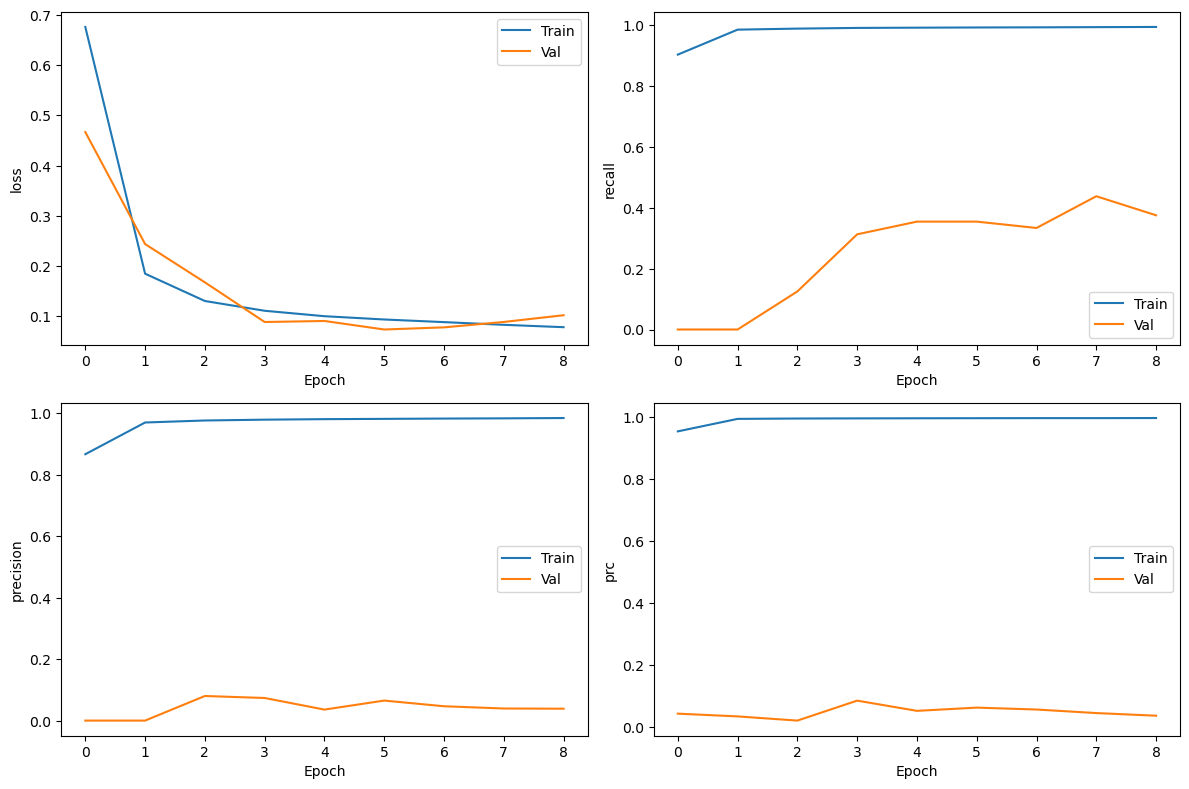

In [41]:
plot_training_metrics(history)

It's overfitting VERY much, which calls for more regularization! 

Anyway, lets continue with this model.

In [42]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: eaa49cd62977442cbb56f3ffab5565b9
model_uri: models:/m-9fe0809290914a759e339435752da764


In [43]:
model_name = "Credit_Card_Approval_Neaural_Network"
challenger = mlflow.register_model(
    model_uri = model_uri, 
    name = model_name, 
    tags={
        "project": "Credit Card Approval",
        "model_family": "Neaural Network"
    }
)

client.set_registered_model_alias(
    name=model_name,
    alias="challenger",
    version=challenger.version
)

Successfully registered model 'Credit_Card_Approval_Neaural_Network'.
2025/12/17 10:43:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_Neaural_Network, version 1
Created version '1' of model 'Credit_Card_Approval_Neaural_Network'.


In [44]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [45]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.batch_size,params.batch_norm_0,params.learning_rate,params.input_layer,params.l2_0,...,params.l2_4,params.dropout_1,params.l2_5,params.units_4,params.units_5,params.dropout_3,params.units_2,params.dropout_rate_3,params.dropout_rate_1,params.dropout_rate_0
9,2913b57145c347dbaf5107b3cf89f210,0.250000,0.291667,0.218750,0.997538,4096,True,0.0031697406709218275,224,0.00013947261591806066,...,0.0010984069415282492,False,0.000651395863273186,128,128,False,192,None,None,None
3,8edd5a455a644182a03b347a27f830b6,0.181818,0.125000,0.333333,0.998417,4096,False,0.0027832536499391015,192,0.0011163221329841852,...,0.00038153282046034736,False,0.0019421112733855879,96,96,False,128,None,None,None
20,0c0f93625f6940f9a93e86ac7326fa68,0.138249,0.312500,0.088757,0.994519,4096,True,0.008891542236060765,224,0.0008837386860965096,...,0.0005415442011322731,False,None,64,None,False,128,None,None,None
12,9f2f26d2498b4f4c85dd7b6b9e3836b0,0.125413,0.395833,0.074510,0.992233,4096,True,0.0035054927077374557,288,0.00031021228665900554,...,0.00039609460506891115,False,0.0031230392834394097,160,128,False,192,None,None,None
48,ed2d278e74c94ca5ae91ad63931267e9,0.119658,0.145833,0.101449,0.996981,2048,False,0.004907795953447125,128,0.0010277766407886808,...,None,False,None,None,None,None,32,None,None,0.4572647793050309
17,937ab4dcd0c74687ba4b830d677a1c6e,0.117647,0.083333,0.200000,0.998241,4096,True,0.005454999241310457,320,0.0012055010468904456,...,0.0002710672857840259,False,0.0038112853513126103,96,96,False,192,None,None,None
8,e21e8b28f899428f9f67fa3fd00e0f8a,0.115385,0.062500,0.750000,0.998652,4096,True,0.0032069237409455835,224,0.00012605819380786355,...,0.0008832002854236712,False,0.0005576244199014252,128,128,False,192,None,None,None
46,5e7849a899b1453f97cd8bf34b24efa8,0.114286,0.333333,0.068966,0.992731,2048,True,0.005469095538312463,256,0.0004670575423030429,...,None,False,None,None,None,None,64,None,None,0.30008512014111266
23,f35a64df475342c98fc3dc1d82e30108,0.103560,0.333333,0.061303,0.991881,4096,True,0.004176953591186359,320,0.0008864006393021272,...,0.000861991105837426,False,None,32,None,True,128,0.25428374154299505,None,None
40,ccd6e25f01ad4dd2aa2c54a2ac6fef05,0.100239,0.437500,0.056604,0.988950,2048,True,0.0005206259834846063,384,0.0005443601740689402,...,0.002486441988773342,True,None,32,None,True,160,0.31089646107830304,0.2936272629433838,0.3442422873740155


In [46]:
loaded_model = mlflow.keras.load_model(model_uri)

In [47]:
# Predict on the val set
val_predictions = loaded_model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


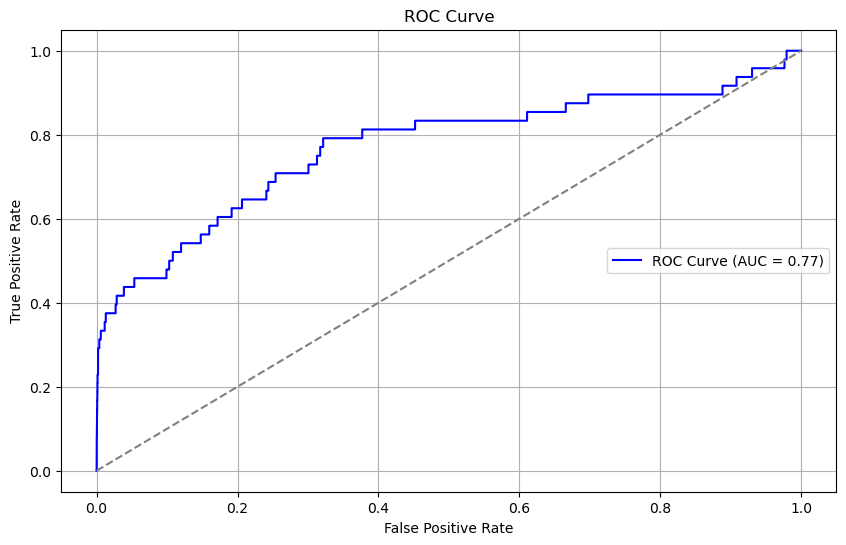

0.7712901134918306

In [48]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:77: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


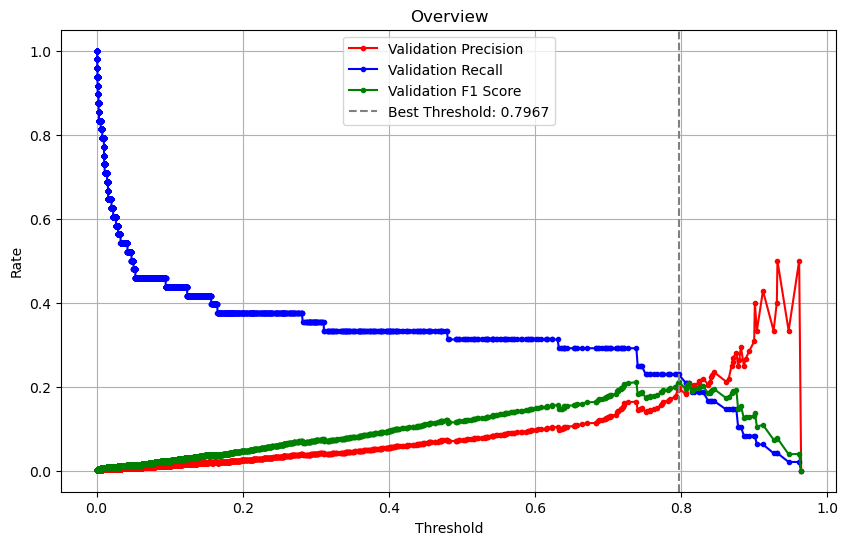

In [49]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)
client.log_param(parent_run_id, 'best_threshold', best_threshold)
client.set_model_version_tag(
    name=model_name,
    version=challenger.version,
    key="best_threshold",
    value=str(best_threshold)
)

In [55]:
# Test model on test set
test_predictions = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 6ms/step


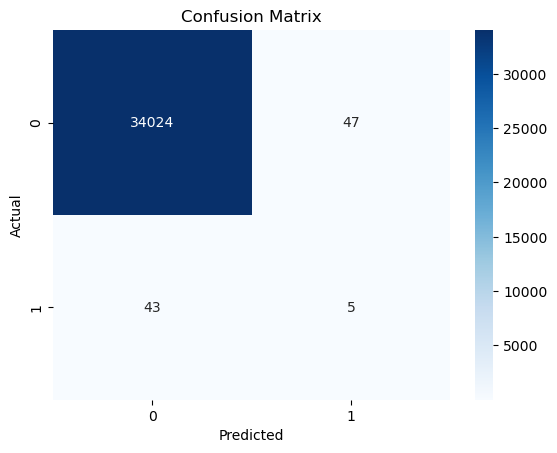

Accuracy     = 1.0
Recall       = 0.1
Precision    = 0.1
F1           = 0.1


In [60]:
challenger_result = get_result(
    Y_test, 
    test_predictions, 
    best_threshold, 
    visualize=True
)

This is definitely not a great result. We could only find 5 out of 48 risky customers...

It could be interesting to see, how close our best threshold is to the actual best threshold for the test set, when we want to maximize the F1 score. Let's see.

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:77: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


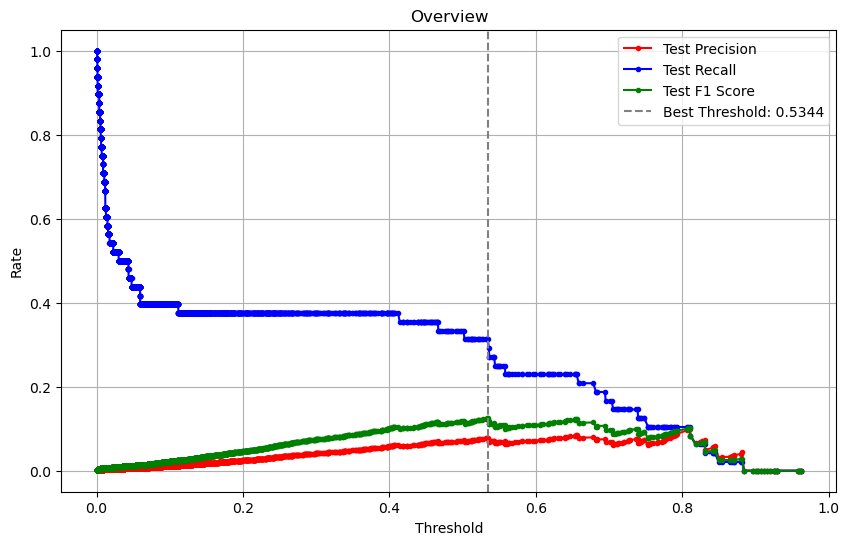

Difference between thresholds: 0.2623223


In [52]:
best_threshold_test = get_best_threshold('Test', Y_test, test_predictions)
print('Difference between thresholds:', best_threshold - best_threshold_test)

Not that close...

Let's see if it's better than the current champion model (if this is not the first time running)

In [54]:
challenge_champion(
    client, 
    algorithm_name = 'neuralnetwork',
    model_name = model_name, 
    X_test = X_test,
    Y_test = Y_test, 
    challenger_metrics = challenger_result, 
    competing_metric = 'f1'
)

No existing champion model found.
Setting current model as champion.
